# Autofluorescence correction

# Import packages

In [1]:
import sys

sys.path.append('..')

import numpy as np
import matplotlib.pyplot as plt
import glob

# Import images

In [2]:
from membranequant.funcs import load_image

path = '../test_datasets/dataset1_n2/00/'
ch1 = load_image(glob.glob('%s/*488 SP 535-50*' % path)[0])
ch2 = load_image(glob.glob('%s/*488 SP 630-75*' % path)[0])

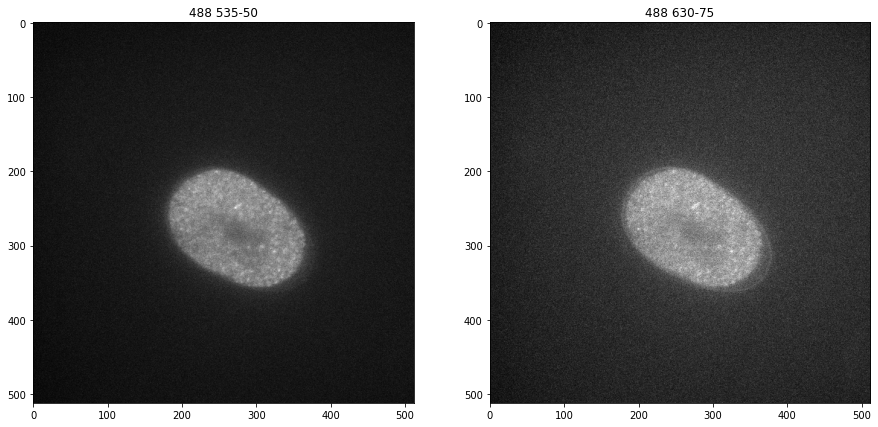

In [3]:
%matplotlib inline
fig, (ax1, ax2) = plt.subplots(1,2)
ax1.imshow(ch1, cmap='gray')
ax2.imshow(ch2, cmap='gray')
ax1.set_title('488 535-50')
ax2.set_title('488 630-75')
plt.gcf().set_size_inches(15,15)

# Specify ROI

Can specify an ROI using the def_roi function, or load a pre-saved ROI

In [7]:
from membranequant.roi import def_roi
%matplotlib tk
roi = def_roi(ch1, spline=True, periodic=True)
print(roi.shape)

# roi = np.loadtxt(path + '/ROI.txt')

AttributeError: 'NoneType' object has no attribute 'shape'

# Mask images

In [ ]:
from membranequant.funcs import offset_coordinates
from membranequant.autofluorescence import make_mask

expand = 10
roi_expanded = offset_coordinates(roi, expand)
mask = make_mask(shape=ch1.shape, roi=roi_expanded)

ch1_masked = ch1 * mask
ch2_masked = ch2 * mask

%matplotlib inline
fig, (ax1, ax2) = plt.subplots(1,2)
ax1.imshow(ch1_masked, cmap='gray')
ax2.imshow(ch2_masked, cmap='gray')
ax1.set_title('488 535-50')
ax2.set_title('488 630-75')
plt.gcf().set_size_inches(15,15)

# Get channel correlation

### Perform linear regression on inter-channel pixel intensities

In [ ]:
from scipy.optimize import curve_fit

def get_correlation(ch1_masked, ch2_masked):
    # Flatten
    xdata = ch2_masked.flatten()
    ydata = ch1_masked.flatten()

    # Remove nans (masked regions)
    xdata = xdata[~np.isnan(xdata)]
    ydata = ydata[~np.isnan(ydata)]

    # Perform linear regression
    popt, pcov = curve_fit(lambda x, slope, intercept: slope * x + intercept, xdata, ydata)
    gradient = popt[0]
    intercept = popt[1]
    return gradient, intercept, xdata, ydata

gradient, intercept, xdata, ydata = get_correlation(ch1_masked, ch2_masked)
print('Gradient = %s' % gradient)
print('Intercept = %s' % intercept)

### Plot correlation

In [ ]:
def plot_correlation(gradient, intercept, xdata, ydata):
    plt.scatter(xdata, ydata, s=1)
    xline = np.linspace(np.percentile(xdata, 0.01), np.percentile(xdata, 99.99), 20)
    yline = gradient * xline + intercept
    plt.plot(xline, yline, c='r')
    plt.xlim(np.percentile(xdata, 0.01), np.percentile(xdata, 99.99))
    plt.ylim(np.percentile(ydata, 0.01), np.percentile(ydata, 99.99))
    plt.xlabel('488 630-75')
    plt.ylabel('488 535-50')
    plt.gcf().set_size_inches(10,10)
    
plot_correlation(gradient, intercept, xdata, ydata)

# Gaussian blur

### Apply filter

In [ ]:
from scipy.ndimage.filters import gaussian_filter

sigma = 1

ch1_filtered = gaussian_filter(ch1, sigma=sigma)
ch2_filtered = gaussian_filter(ch2, sigma=sigma)

%matplotlib inline
fig, (ax1, ax2) = plt.subplots(1,2)
ax1.imshow(ch1_filtered, cmap='gray')
ax2.imshow(ch2_filtered, cmap='gray')
ax1.set_title('488 535-50')
ax2.set_title('488 630-75')
plt.gcf().set_size_inches(15,15)

### Get channel correlation

Using these filtered images, we get a much cleaner correlation between the channels, which is less dominated by noise

In [ ]:
ch1_filtered_masked = ch1_filtered * mask
ch2_filtered_masked = ch2_filtered * mask
gradient2, intercept2, xdata2, ydata2 = get_correlation(ch1_filtered_masked, ch2_filtered_masked)
print('Gradient = %s' % gradient2)
print('Intercept = %s' % intercept2)

plot_correlation(gradient2, intercept2, xdata2, ydata2)

# AfCorrection class

In [ ]:
from membranequant.funcs import direcslist
from membranequant.autofluorescence import AfCorrelation

path = '../test_datasets/dataset1_n2/'
paths = direcslist(path, 0)
ch1_regex = '*488 SP 535-50*'
ch2_regex = '*488 SP 630-75*'
roi_regex = '*ROI*'

# Set up class
af = AfCorrelation(paths=paths, ch1_regex=ch1_regex, ch2_regex=ch2_regex, roi_regex=roi_regex, sigma=1, expand=10)

# Print parameters
print(af.params)

In [ ]:
# Plot correlation
% matplotlib inline
af.plot_correlation(s=0.1)
plt.gcf().set_size_inches(10,10)

# Autofluorescence subtraction

In [ ]:
from membranequant.autofluorescence import af_subtraction

### N2

In [ ]:
path = '../test_datasets/dataset1_n2/00/'
ch1 = load_image(glob.glob('%s/*488 SP 535-50*' % path)[0])
ch2 = load_image(glob.glob('%s/*488 SP 630-75*' % path)[0])

af_corrected = af_subtraction(ch1, ch2, *af.params)

%matplotlib inline

fig, (ax1, ax2) = plt.subplots(1,2)
ax1.imshow(af_corrected, cmap='gray')
ax1.set_title('Autofluorescence corrected image')
ax2.plot(ch1[250, :], label='488 SP 535-50')
ax2.plot(ch2[250, :], label='488 SP 630-75')
ax2.plot(af_corrected[250, :], label='Autofluorescence corrected')
ax2.set_title('Cross sections')
ax2.set_xlabel('Position')
ax2.set_ylabel('Pixel intensity')
ax2.legend()
plt.gcf().set_size_inches(20,7)

### PAR-2

In [ ]:
path = '../test_datasets/dataset2_par2_neon/00/'
ch1 = load_image(glob.glob('%s/*488 SP 535-50*' % path)[0])
ch2 = load_image(glob.glob('%s/*488 SP 630-75*' % path)[0])

af_corrected = af_subtraction(ch1, ch2, *af.params)

%matplotlib inline

fig, (ax1, ax2) = plt.subplots(1,2)
ax1.imshow(af_corrected, cmap='gray')
ax1.set_title('Autofluorescence corrected image')
ax2.plot(ch1[250, :], label='488 SP 535-50')
ax2.plot(ch2[250, :], label='488 SP 630-75')
ax2.plot(af_corrected[250, :], label='Autofluorescence corrected')
ax2.set_title('Cross sections')
ax2.set_xlabel('Position')
ax2.set_ylabel('Pixel intensity')
ax2.legend()
plt.gcf().set_size_inches(20,7)

In [ ]:
from membranequant.funcs import save_img

for path in direcslist('../test_datasets/dataset2_par2_neon/'):
    ch1 = load_image(glob.glob('%s/*488 SP 535-50*' % path)[0])
    ch2 = load_image(glob.glob('%s/*488 SP 630-75*' % path)[0])
    af_corrected = af_subtraction(ch1, ch2, *af.params)
    save_img(af_corrected, '%s/af_corrected.tif' % path)